In [ ]:
import random
import numpy as np
import os
from pathlib import Path
import shutil
import torchvision
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback, ShowGraphCallback
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

#Load data with data augmentation
path = Path("/content/drive/My Drive/four_genre_posters_updated")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# get list of all image files in 'path'
image_files = get_image_files(path)

# dataset size
num_samples = len(image_files)
# the size of the test set
test_frac = 0.2
num_test = int(num_samples*test_frac)

# list indices of all images
idxs = np.arange(num_samples)
# randomly shuffle the indices
np.random.shuffle(idxs)
# split indices into those for train-validation set and test set
trainvalid_idxs, test_idxs = idxs[num_test:], idxs[:num_test]

# image files corresponding to the train-validation set and the test set
trainvalid_image_files, test_image_files = image_files[trainvalid_idxs], image_files[test_idxs]

print(len(trainvalid_image_files), len(test_image_files))


1044 261


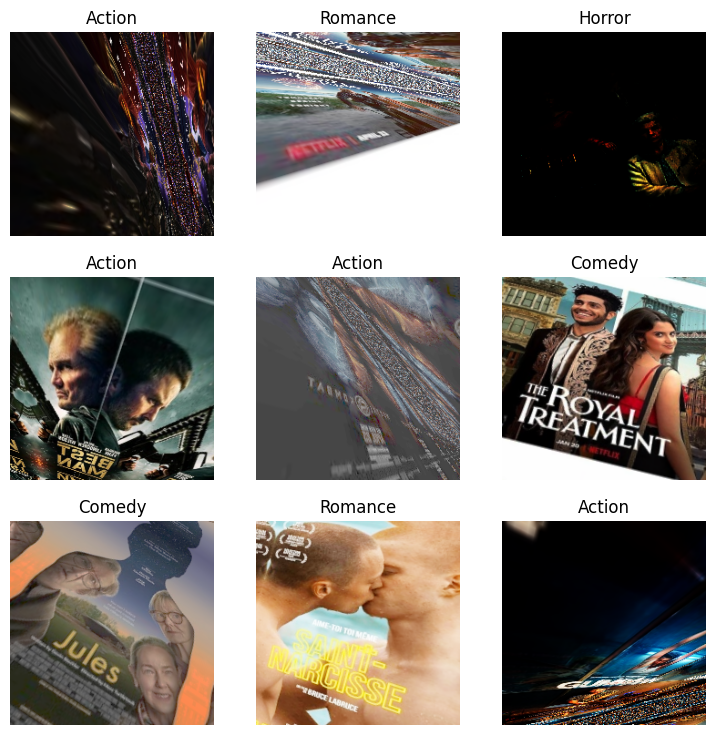

In [ ]:

# Define data augmentation
batch_tfms = aug_transforms(mult=4, do_flip=True, max_rotate=10.0, min_zoom=1.0, max_zoom=1.1)
batch_tfms += [Normalize.from_stats(*imagenet_stats)]

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=lambda x: trainvalid_image_files,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_y=lambda x: x.parent.name,
                   item_tfms=Resize(224),
                   batch_tfms=batch_tfms)

# Create DataLoaders from the DataBlock
dls = dblock.dataloaders(trainvalid_image_files,bs=32)

dls.show_batch()


In [ ]:

class BaseMLP(Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


input_size = 224*224*3
hidden_size = 512
num_classes = 4


base_learner = Learner(dls, BaseMLP(input_size, hidden_size, num_classes), metrics=accuracy)




epoch,train_loss,valid_loss,accuracy,time
0,98.307678,140.225250,0.230769,00:31
1,182.301285,116.033661,0.240385,00:03
2,339.479492,518.506897,0.240385,00:03
3,561.797363,250.285324,0.355769,00:03
4,566.028442,165.159760,0.336538,00:03
5,427.561371,156.480621,0.442308,00:03
6,299.409180,50.220783,0.312500,00:03
7,204.650528,36.853874,0.408654,00:03
8,138.770264,25.465603,0.350962,00:03
9,93.509415,16.049801,0.307692,00:03


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


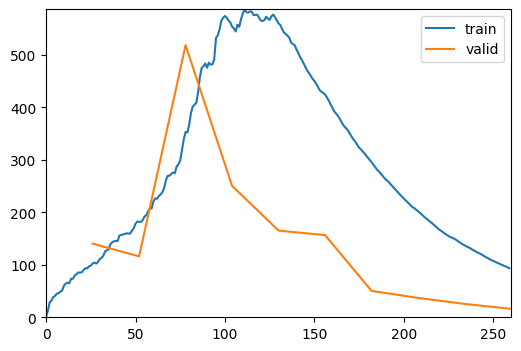

In [ ]:
base_learner.fit_one_cycle(10, 1e-2, cbs=ShowGraphCallback())

In [ ]:


# Create learners with the specified pre-trained model architectures and callbacks
learn_vgg = vision_learner(dls, vgg16,
                           metrics=[accuracy, F1Score(average='weighted')],
                           cbs = [ShowGraphCallback(), EarlyStoppingCallback(patience=10),SaveModelCallback(fname='best_model_vgg')])
learn_resnet = vision_learner(dls, resnet50,
                              metrics=[accuracy, F1Score(average='weighted')],
                              cbs = [ShowGraphCallback(), EarlyStoppingCallback(patience=10),SaveModelCallback(fname='best_model_resnet')])
learn_effnet = vision_learner(dls, efficientnet_b0,
                             metrics=[accuracy, F1Score(average='weighted')],
                             cbs = [ShowGraphCallback(), EarlyStoppingCallback(patience=10),SaveModelCallback(fname='best_model_effnet')])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-d

SuggestedLRs(valley=0.0003981071640737355)

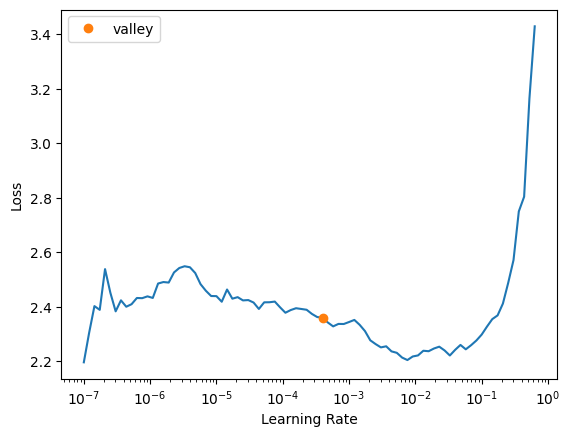

In [ ]:
learn_vgg.lr_find()

SuggestedLRs(valley=0.0003981071640737355)

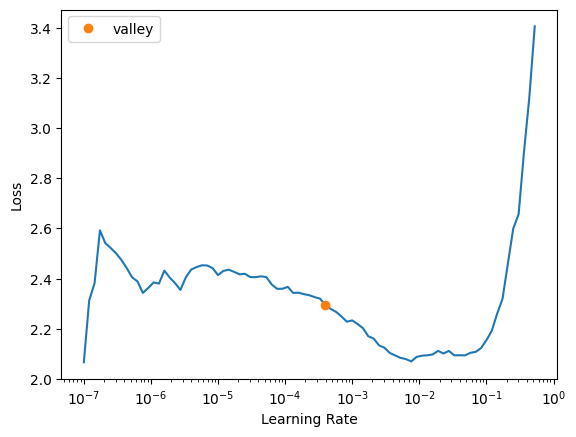

In [ ]:
learn_resnet.lr_find()

SuggestedLRs(valley=0.0003311311302240938)

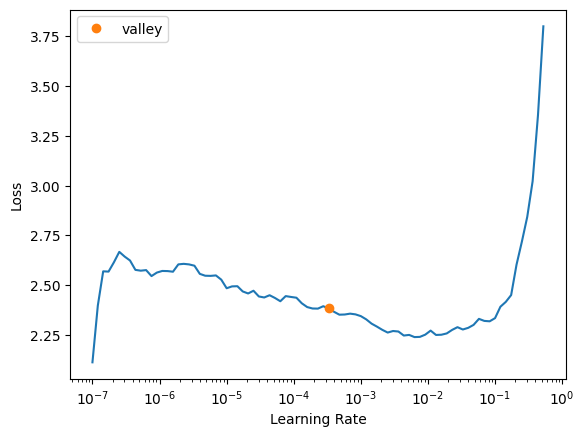

In [ ]:
learn_effnet.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.104836,1.934586,0.572115,0.563532,00:06


Better model found at epoch 0 with valid_loss value: 1.9345860481262207.


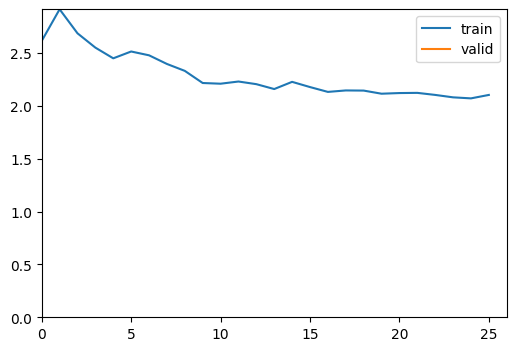

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.616383,1.196514,0.605769,0.606951,00:13
1,1.490366,1.161867,0.586538,0.582542,00:14
2,1.376858,1.130184,0.591346,0.595726,00:14
3,1.354402,1.111794,0.591346,0.586612,00:14
4,1.283181,1.147974,0.605769,0.608542,00:14
5,1.217088,1.078170,0.586538,0.587519,00:14
6,1.170632,1.041254,0.625000,0.624686,00:14
7,1.127598,1.192333,0.610577,0.610759,00:14
8,1.092340,1.295385,0.620192,0.626340,00:14
9,1.069737,1.078992,0.620192,0.621203,00:14


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 0 with valid_loss value: 1.1965137720108032.


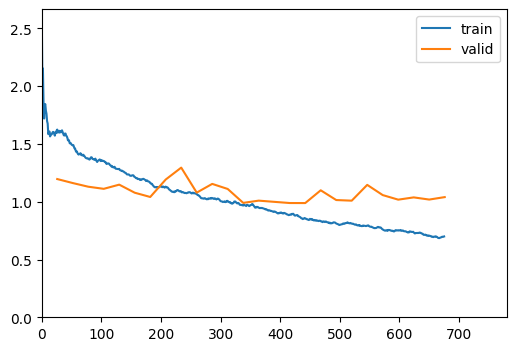

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 1 with valid_loss value: 1.1618674993515015.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 2 with valid_loss value: 1.1301839351654053.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 3 with valid_loss value: 1.1117936372756958.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 5 with valid_loss value: 1.0781702995300293.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 6 with valid_loss value: 1.0412535667419434.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

Better model found at epoch 12 with valid_loss value: 0.9902374744415283.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 15 with valid_loss value: 0.9889135360717773.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 16 with valid_loss value: 0.9885428547859192.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

No improvement since epoch 16: early stopping
Model: VGG16


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


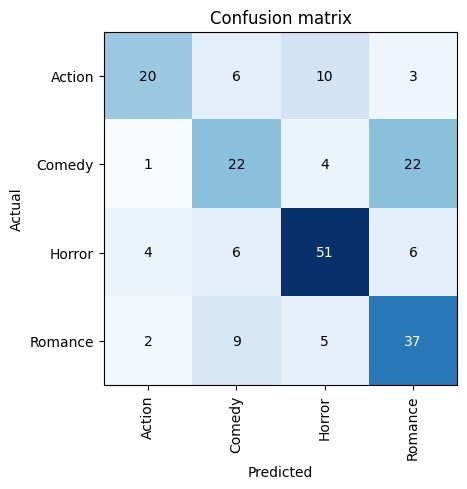

In [ ]:
learn_vgg.fine_tune(30,base_lr=0.0063095735386013985, wd=0.5)


print("Model: VGG16")
interp = ClassificationInterpretation.from_learner(learn_vgg)
interp.plot_confusion_matrix()



epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.973682,1.402855,0.567308,0.570783,00:08


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 0 with valid_loss value: 1.4028548002243042.


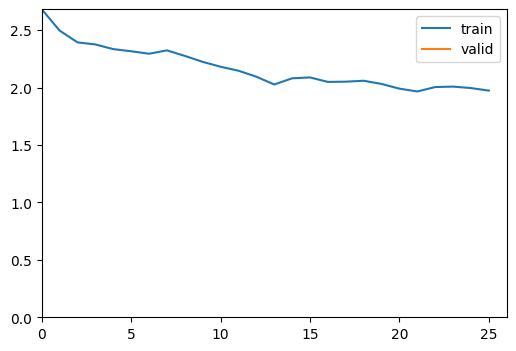

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.791091,1.155372,0.620192,0.617499,00:10
1,1.534255,1.090076,0.615385,0.616005,00:10
2,1.416315,1.057223,0.620192,0.621015,00:11
3,1.350544,1.124616,0.615385,0.617530,00:10
4,1.313075,1.114394,0.692308,0.688409,00:10
5,1.223135,1.190145,0.610577,0.610681,00:10
6,1.140263,1.156930,0.634615,0.633832,00:11
7,1.068376,1.082104,0.658654,0.653964,00:10
8,0.991924,1.088683,0.682692,0.684089,00:10
9,0.931673,1.027218,0.658654,0.655592,00:10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 0 with valid_loss value: 1.155371904373169.


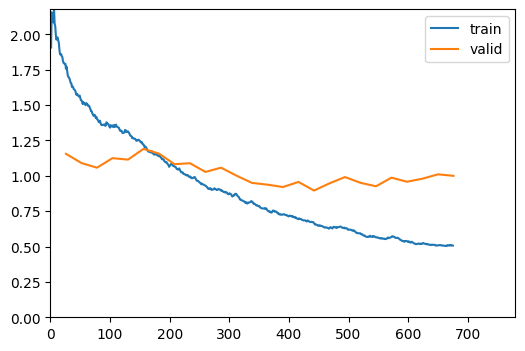

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 1 with valid_loss value: 1.0900763273239136.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 2 with valid_loss value: 1.057222843170166.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

Better model found at epoch 9 with valid_loss value: 1.027217984199524.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 11 with valid_loss value: 1.0011255741119385.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 12 with valid_loss value: 0.9498962759971619.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 13 with valid_loss value: 0.9373102784156799.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 14 with valid_loss value: 0.9205799698829651.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 16 with valid_loss value: 0.8956302404403687.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

No improvement since epoch 16: early stopping
Model: RESNET50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


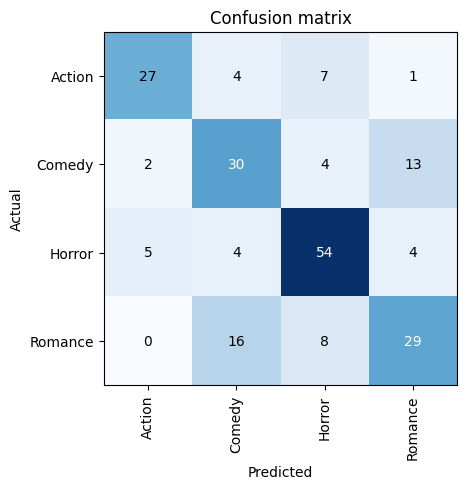

In [ ]:
learn_resnet.fine_tune(30,base_lr=0.002511886414140463, wd=0.8)

print("Model: RESNET50")
interp = ClassificationInterpretation.from_learner(learn_resnet)
interp.plot_confusion_matrix()


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.318592,1.389132,0.403846,0.400727,00:05


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 0 with valid_loss value: 1.389132022857666.


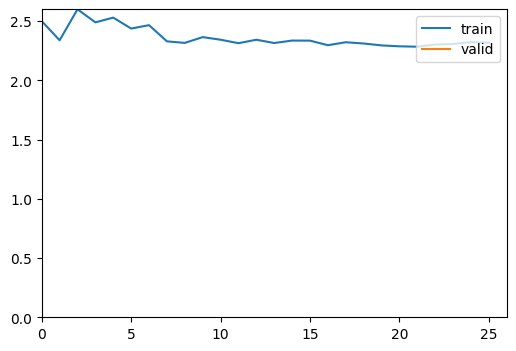

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.005130,1.322578,0.432692,0.428419,00:06
1,1.948350,1.270836,0.427885,0.422516,00:06
2,1.903767,1.219949,0.509615,0.506476,00:06
3,1.897015,1.142718,0.528846,0.521458,00:06
4,1.830018,1.101765,0.543269,0.535707,00:06
5,1.778684,1.094746,0.562500,0.557048,00:06
6,1.743622,1.073471,0.567308,0.564607,00:06
7,1.660614,1.082948,0.562500,0.565050,00:06
8,1.612498,1.098828,0.562500,0.565109,00:06
9,1.599010,1.152706,0.543269,0.543709,00:06


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 0 with valid_loss value: 1.322577714920044.


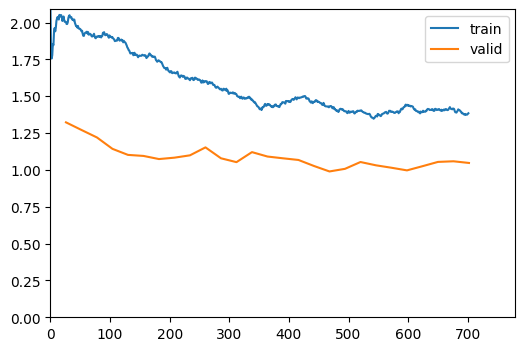

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 1 with valid_loss value: 1.2708356380462646.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 2 with valid_loss value: 1.2199485301971436.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 3 with valid_loss value: 1.1427184343338013.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 4 with valid_loss value: 1.1017650365829468.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 5 with valid_loss value: 1.0947463512420654.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 6 with valid_loss value: 1.0734714269638062.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

Better model found at epoch 11 with valid_loss value: 1.0525338649749756.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

Better model found at epoch 16 with valid_loss value: 1.0265140533447266.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 17 with valid_loss value: 0.9894154071807861.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

No improvement since epoch 17: early stopping
Model: EFFICIENTNET


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


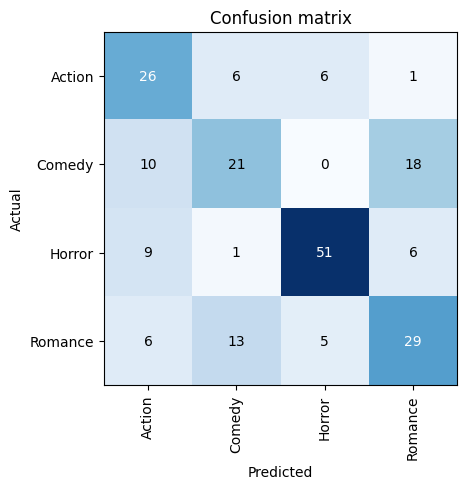

In [ ]:

learn_effnet.fine_tune(30, base_lr=0.0003311311302240938, wd=0.0)


print("Model: EFFICIENTNET")
interp = ClassificationInterpretation.from_learner(learn_effnet)
interp.plot_confusion_matrix()


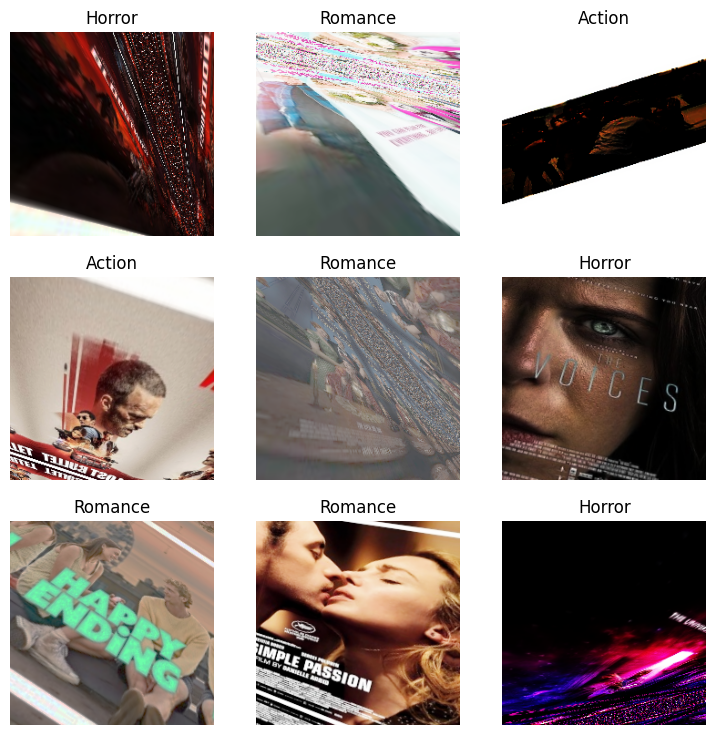

In [ ]:
# Create a DataLoader for testing
test_dls = dblock.dataloaders(test_image_files, bs=32)

dls.show_batch()


In [ ]:
# get predictions and targets
vgg_preds, vgg_targets = learn_vgg.get_preds(dl=test_dls.valid)
resnet_preds, resnet_targets = learn_resnet.get_preds(dl=test_dls.valid)
effnet_preds, effnet_targets = learn_effnet.get_preds(dl=test_dls.valid)


In [ ]:
# Get the actual class labels
class_labels = test_dls.vocab

print(class_labels)

['Action', 'Comedy', 'Horror', 'Romance']


In [ ]:
# Calculate classification report
classification_rep = classification_report(vgg_targets, vgg_preds.argmax(dim=1))
print("Classification Report for VGG model:")
print(classification_rep)

print('_________________________________________________________________')

classification_rep = classification_report(resnet_targets, resnet_preds.argmax(dim=1))
print("Classification Report for Resnet model:")
print(classification_rep)

print('_________________________________________________________________')

classification_rep = classification_report(effnet_targets, effnet_preds.argmax(dim=1))
print("Classification Report for Efficientnet model:")
print(classification_rep)


Classification Report for VGG model:
              precision    recall  f1-score   support

           0       0.74      0.51      0.61        39
           1       0.51      0.45      0.48        49
           2       0.73      0.76      0.74        67
           3       0.54      0.70      0.61        53

    accuracy                           0.62       208
   macro avg       0.63      0.61      0.61       208
weighted avg       0.63      0.62      0.62       208

_________________________________________________________________
Classification Report for Resnet model:
              precision    recall  f1-score   support

           0       0.79      0.69      0.74        39
           1       0.56      0.61      0.58        49
           2       0.74      0.81      0.77        67
           3       0.62      0.55      0.58        53

    accuracy                           0.67       208
   macro avg       0.68      0.66      0.67       208
weighted avg       0.68      0.67      0.6

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


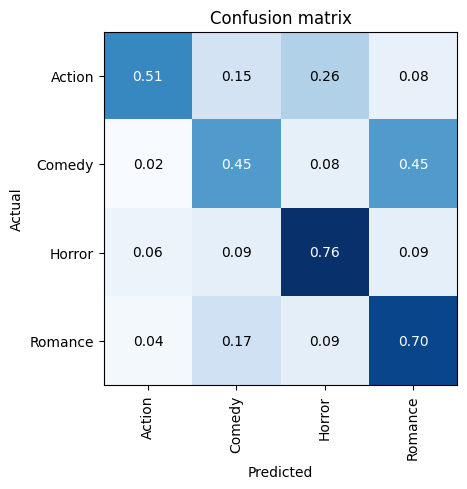

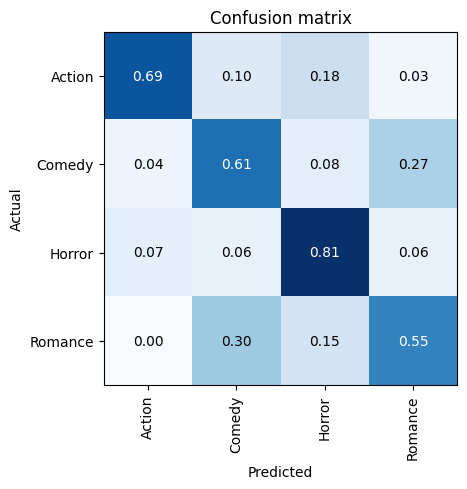

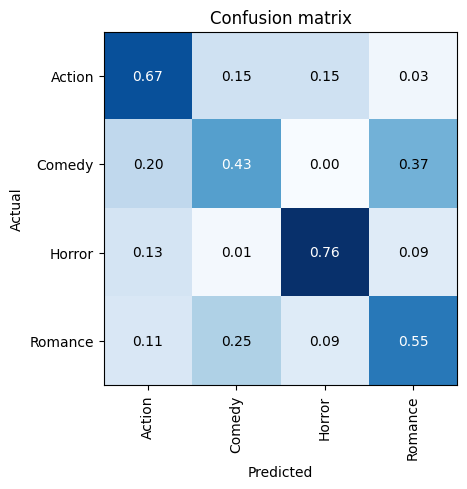

In [ ]:

interp_vgg = ClassificationInterpretation.from_learner(learn_vgg, dl=test_dls.valid)
interp_resnet = ClassificationInterpretation.from_learner(learn_resnet, dl=test_dls.valid)
interp_effnet = ClassificationInterpretation.from_learner(learn_effnet, dl=test_dls.valid)

# Show normalized confusion matrix
interp_vgg.plot_confusion_matrix(normalize=True)
interp_resnet.plot_confusion_matrix(normalize=True)
interp_effnet.plot_confusion_matrix(normalize=True)
